In [51]:
import numpy as np
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from datetime import datetime
import torch.nn.functional as F
from torchsummary import summary
from torch.autograd import Variable
from torchvision.datasets import MNIST

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.autograd.set_detect_anomaly(True)

# 1 - Implement VAE-GAN

In [53]:
latent_dim = 128
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Encoder(nn.Module):
  def __init__(self):
    super(Encoder,self).__init__()
    self.conv1=nn.Conv2d(1,64,5,stride=2,padding=2)   #in_channels=3)
    self.bn1=nn.BatchNorm2d(64)
    self.conv2=nn.Conv2d(64,128,5,stride=2,padding=2)
    self.bn2=nn.BatchNorm2d(128)
    self.relu=nn.LeakyReLU(0.2)
    self.fc1=nn.Linear(128*7*7,2048)
    self.bn3=nn.BatchNorm1d(2048)
    self.fc_mean=nn.Linear(2048,latent_dim)
    self.fc_logvar=nn.Linear(2048,latent_dim)   #latent dim=128
  
  def forward(self,x):
    batch_size=x.size()[0]
    out=self.relu(self.bn1(self.conv1(x)))
    out=self.relu(self.bn2(self.conv2(out)))
    out=out.view(batch_size,-1)
    out=self.relu(self.bn3(self.fc1(out)))
    mean=self.fc_mean(out)
    logvar=self.fc_logvar(out)
    
    return mean,logvar
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder,self).__init__()
    self.fc1=nn.Linear(latent_dim,7*7*256)
    self.bn1=nn.BatchNorm1d(7*7*256)
    self.relu=nn.LeakyReLU(0.2)
    self.deconv1=nn.ConvTranspose2d(256,128,6, stride=2, padding=2)
    self.bn2=nn.BatchNorm2d(128)
    self.deconv2=nn.ConvTranspose2d(128,32,6, stride=2, padding=2)
    self.bn3=nn.BatchNorm2d(32)
    self.deconv3=nn.ConvTranspose2d(32,1,5, stride=1, padding=2)
    self.tanh=nn.Tanh()

  def forward(self,x):
    # batch_size=x.size()[0]
    x=self.relu(self.bn1(self.fc1(x)))
    x=x.view(-1,256,7,7)
    x=self.relu(self.bn2(self.deconv1(x)))
    x=self.relu(self.bn3(self.deconv2(x)))
    x=self.tanh(self.deconv3(x))
    return x
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.conv1=nn.Conv2d(1,32,5,stride=2,padding=2)
    self.relu=nn.LeakyReLU(0.2)
    self.conv2=nn.Conv2d(32,64,5,stride=2,padding=2)
    self.bn1=nn.BatchNorm2d(64)
    self.fc1=nn.Linear(7*7*64,512)
    self.bn2=nn.BatchNorm1d(512)
    self.fc2=nn.Linear(512,1)
    self.sigmoid=nn.Sigmoid()

  def forward(self,x):
    x=self.relu(self.conv1(x))
    x=self.relu(self.bn1(self.conv2(x)))
    x=x.view(-1,64*7*7)
    x1=x
    x=self.relu(self.fc1(x))
    x=self.sigmoid(self.fc2(x))

    return x,x1
class VAE_GAN(nn.Module):
  def __init__(self):
    super(VAE_GAN,self).__init__()
    self.encoder=Encoder()
    self.decoder=Decoder()
    self.discriminator=Discriminator()
    self.encoder.apply(weights_init)
    self.decoder.apply(weights_init)
    self.discriminator.apply(weights_init)


  def forward(self,x):
    bs=x.size()[0]
    z_mean,z_logvar=self.encoder(x)
    std = z_logvar.mul(0.5).exp_()
    epsilon=Variable(torch.randn(bs,latent_dim)).to(device)
    z=z_mean+std*epsilon
    x_tilda=self.decoder(z)
      
    return z_mean,z_logvar,x_tilda        

# 2 - Training on MNIST

In [54]:
timestamp = (datetime.now()).strftime("%y%m%d_%H%M%S")
output_path = os.path.join("output", 'VAEGAN_'+timestamp)
if not os.path.exists(output_path):
    os.makedirs(output_path)

## 2.1 - Configuration 

In [55]:
epochs=50
lr=3e-3
alpha=0.01
gamma=15
batch_size = 64
beta_1=0.5
decay=lr/epochs

## 2.2 - Load MNIST

In [56]:
print("[INFO] loading MNIST dataset...")
# Define a transform to normalize the data to the range [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load the training and test datasets
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
# Filter the training and test datasets to include only images with label 2
train_filter = train_dataset.targets == 2
test_filter = test_dataset.targets == 2
train_images = train_dataset.data[train_filter]
test_images = test_dataset.data[test_filter]
# Concatenate the training and test datasets
filtered_images = torch.cat([train_dataset.data, test_dataset.data])
# Expand dimensions to add the channel dimension and normalize
filtered_images = train_images.unsqueeze(1).float()  # Add channel dimension and convert to float
# Create a TensorDataset from the filtered images

train_loader = torch.utils.data.DataLoader(filtered_images, batch_size=batch_size, shuffle=True)
real_batch = next(iter(train_loader))

[INFO] loading MNIST dataset...


## 2.3 Initialize VAE-GAN

GENERATOR

In [57]:
gen=VAE_GAN().to(device)
summary(gen,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,664
       BatchNorm2d-2           [-1, 64, 14, 14]             128
         LeakyReLU-3           [-1, 64, 14, 14]               0
            Conv2d-4            [-1, 128, 7, 7]         204,928
       BatchNorm2d-5            [-1, 128, 7, 7]             256
         LeakyReLU-6            [-1, 128, 7, 7]               0
            Linear-7                 [-1, 2048]      12,847,104
       BatchNorm1d-8                 [-1, 2048]           4,096
         LeakyReLU-9                 [-1, 2048]               0
           Linear-10                  [-1, 128]         262,272
           Linear-11                  [-1, 128]         262,272
          Encoder-12     [[-1, 128], [-1, 128]]               0
           Linear-13                [-1, 12544]       1,618,176
      BatchNorm1d-14                [-1

DISCRIMINATOR

In [58]:
discrim=Discriminator().to(device)
summary(discrim,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             832
         LeakyReLU-2           [-1, 32, 14, 14]               0
            Conv2d-3             [-1, 64, 7, 7]          51,264
       BatchNorm2d-4             [-1, 64, 7, 7]             128
         LeakyReLU-5             [-1, 64, 7, 7]               0
            Linear-6                  [-1, 512]       1,606,144
         LeakyReLU-7                  [-1, 512]               0
            Linear-8                    [-1, 1]             513
           Sigmoid-9                    [-1, 1]               0
Total params: 1,658,881
Trainable params: 1,658,881
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 6.33
Estimated Total Size (MB): 6.51
---------------------------------------

LOSS functions & Optimizers

In [59]:
# Loss and optimizers
criterion = nn.BCELoss().to(device)
optim_E = torch.optim.Adam(gen.encoder.parameters(), lr=lr)
optim_D = torch.optim.Adam(gen.decoder.parameters(), lr=lr)
optim_Dis = torch.optim.Adam(discrim.parameters(), lr=lr * alpha)

## 2.4 - Training

In [60]:
# Fixed noise for evaluation
z_fixed = Variable(torch.randn((64, latent_dim))).to(device)
x_fixed = Variable(real_batch).to(device)
best_prior_loss = float('inf')

prior_loss_list, gan_loss_list, recon_loss_list = [], [], []
dis_real_list, dis_fake_list, dis_prior_list = [], [], []

for epoch in range(epochs):
    for i, data in enumerate(train_loader, 0):
        bs = data.size()[0]
        
        ones_label = Variable(torch.ones(bs, 1)).to(device)
        zeros_label = Variable(torch.zeros(bs, 1)).to(device)
        zeros_label1 = Variable(torch.zeros(64, 1)).to(device)
        datav = Variable(data).to(device)
        
        # Forward pass
        mean, logvar, rec_enc = gen(datav)
        z_p = Variable(torch.randn(64, latent_dim)).to(device)
        x_p_tilda = gen.decoder(z_p)
        
        output = discrim(datav)[0]
        errD_real = criterion(output, ones_label)
        dis_real_list.append(errD_real.item())

        output = discrim(rec_enc)[0]
        errD_rec_enc = criterion(output, zeros_label)
        dis_fake_list.append(errD_rec_enc.item())

        output = discrim(x_p_tilda)[0]
        errD_rec_noise = criterion(output, zeros_label1)
        dis_prior_list.append(errD_rec_noise.item())

        # Discriminator loss
        gan_loss = errD_real + errD_rec_enc + errD_rec_noise
        gan_loss_list.append(gan_loss.item())

        # Generator loss        
        x_l_tilda = discrim(rec_enc)[1]
        x_l = discrim(datav)[1]
        rec_loss = ((x_l_tilda - x_l) ** 2).mean()
        err_dec = gamma * rec_loss - gan_loss
        recon_loss_list.append(rec_loss.item())

        # Encoder loss
        prior_loss = 1 + logvar - mean.pow(2) - logvar.exp()
        prior_loss = (-0.5 * torch.sum(prior_loss)) / torch.numel(mean.data)
        prior_loss_list.append(prior_loss.item())
        err_enc = prior_loss + rec_loss

        optim_Dis.zero_grad()
        optim_D.zero_grad()
        optim_E.zero_grad()

        gan_loss.backward(retain_graph=True)
        err_dec.backward(retain_graph=True)
        err_enc.backward()

        optim_Dis.step()
        optim_D.step()
        optim_E.step()

        if ((i+1) % 100 == 0) or (i == len(train_loader)-1):
            print('[%02d/%d][%d/%d]\tLoss_gan: %.4f\tLoss_prior: %.4f\tRec_loss: %.4f\tdis_real_loss: %0.4f\tdis_fake_loss: %.4f\tdis_prior_loss: %.4f'
                  % (epoch+1, epochs, i+1, len(train_loader),
                     gan_loss.item(), prior_loss.item(), rec_loss.item(), errD_real.item(), errD_rec_enc.item(), errD_rec_noise.item()))

            # Save images
            images = gen.decoder(z_fixed).cpu().detach().numpy()
            images = (images * 0.5 + 0.5)    # Convert from [-1, 1] to [0, 1])
            fig, axes = plt.subplots(8, 8, figsize=(8, 8))
            for i, ax in enumerate(axes.flat):
                ax.imshow(images[i].transpose((1, 2, 0)), cmap='gray')
                ax.axis('off')
            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            plt.savefig(os.path.join(output_path, f'epoch_{epoch + 1}_output.png'), bbox_inches='tight', pad_inches=0.1)
            plt.close()
            
    # Save model if prior loss improves - choose prior loss for the generated image quality
    last_prior_lost = prior_loss_list[-1]
    if last_prior_lost < best_prior_loss:
        best_prior_loss = last_prior_lost
        torch.save({
            'epoch': epoch,
            'gen_state_dict': gen.state_dict(),
            'discrim_state_dict': discrim.state_dict(),
            'optim_E_state_dict': optim_E.state_dict(),
            'optim_D_state_dict': optim_D.state_dict(),
            'optim_Dis_state_dict': optim_Dis.state_dict(),
            'loss': best_prior_loss,
        }, os.path.join(output_path, 'VAEGAN_best_model.pth'))

[01/50][94/94]	Loss_gan: 2.2361	Loss_prior: 0.3914	Rec_loss: 0.0827	dis_real_loss: 0.5806	dis_fake_loss: 0.8226	dis_prior_loss: 0.8329
[02/50][94/94]	Loss_gan: 2.2277	Loss_prior: 0.3800	Rec_loss: 0.0454	dis_real_loss: 0.5784	dis_fake_loss: 0.8166	dis_prior_loss: 0.8327
[03/50][94/94]	Loss_gan: 2.2440	Loss_prior: 0.2868	Rec_loss: 0.0392	dis_real_loss: 0.5599	dis_fake_loss: 0.8463	dis_prior_loss: 0.8379
[04/50][94/94]	Loss_gan: 2.2402	Loss_prior: 0.2393	Rec_loss: 0.0223	dis_real_loss: 0.5750	dis_fake_loss: 0.8306	dis_prior_loss: 0.8345
[05/50][94/94]	Loss_gan: 2.2150	Loss_prior: 0.2746	Rec_loss: 0.0339	dis_real_loss: 0.5616	dis_fake_loss: 0.8211	dis_prior_loss: 0.8324
[06/50][94/94]	Loss_gan: 2.2281	Loss_prior: 0.2168	Rec_loss: 0.0235	dis_real_loss: 0.5761	dis_fake_loss: 0.8217	dis_prior_loss: 0.8303
[07/50][94/94]	Loss_gan: 2.2463	Loss_prior: 0.1801	Rec_loss: 0.0264	dis_real_loss: 0.5831	dis_fake_loss: 0.8286	dis_prior_loss: 0.8346
[08/50][94/94]	Loss_gan: 2.2259	Loss_prior: 0.1959	Rec_

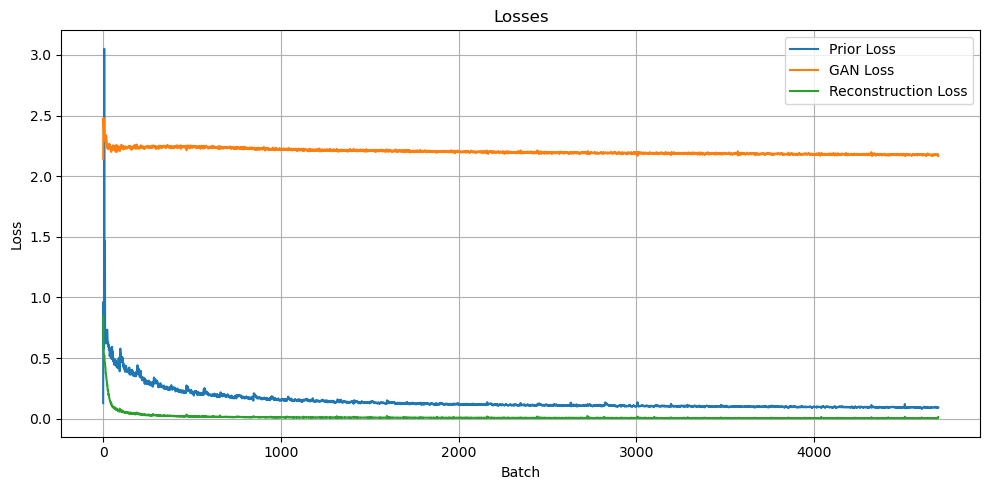

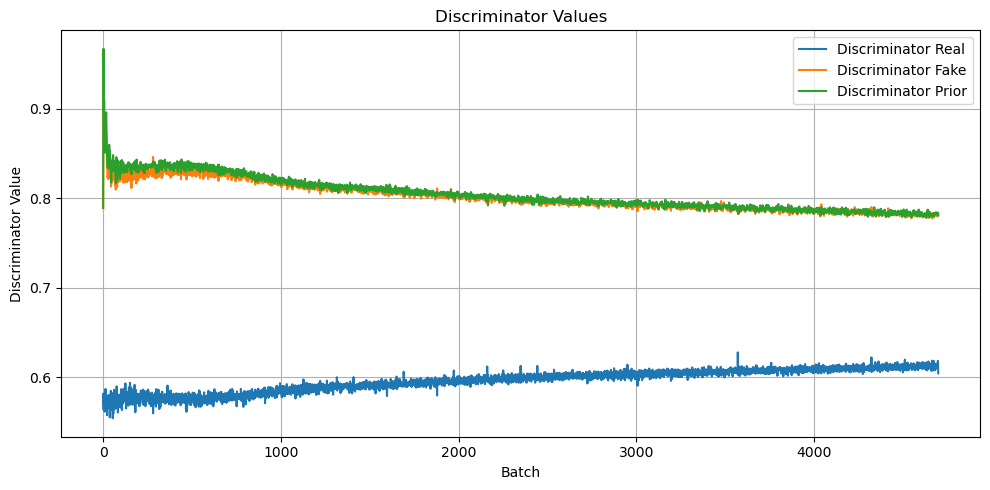

In [61]:
# First figure
plt.figure(figsize=(10, 5))
plt.plot(prior_loss_list, label='Prior Loss')
plt.plot(gan_loss_list, label='GAN Loss')
plt.plot(recon_loss_list, label='Reconstruction Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Losses')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_path, 'plot_losses.png'))
plt.show()
plt.close()

# Second figure
plt.figure(figsize=(10, 5))
plt.plot(dis_real_list, label='Discriminator Real')
plt.plot(dis_fake_list, label='Discriminator Fake')
plt.plot(dis_prior_list, label='Discriminator Prior')
plt.xlabel('Batch')
plt.ylabel('Discriminator Value')
plt.title('Discriminator Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_path, 'plot_discriminator_values_.png'))
plt.show()
plt.close()

In [64]:
# Define the output file path
output_file_path = os.path.join(output_path, 'losses.txt') 

# Open the file in write mode
with open(output_file_path, 'w') as f:
    f.write("prior_loss_list: " + ', '.join(map(str, prior_loss_list)) + '\n')
    f.write("gan_loss_list: " + ', '.join(map(str, gan_loss_list)) + '\n')
    f.write("recon_loss_list: " + ', '.join(map(str, recon_loss_list)) + '\n')
    f.write("dis_real_list: " + ', '.join(map(str, dis_real_list)) + '\n')
    f.write("dis_fake_list: " + ', '.join(map(str, dis_fake_list)) + '\n')
    f.write("dis_prior_list: " + ', '.join(map(str, dis_prior_list)) + '\n')

print(f"Lists have been saved to {output_file_path}")

Lists have been saved to output\VAEGAN_240706_152158\losses.txt


# 3 - Test on MNIST

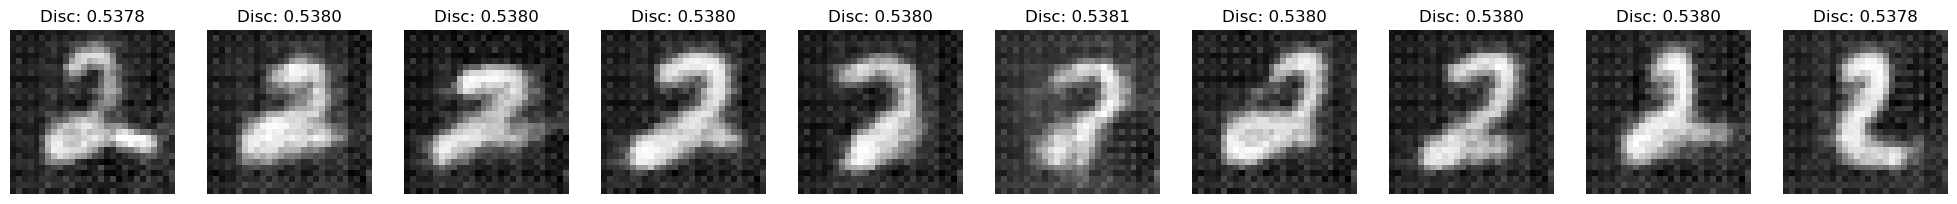

In [63]:
# Load the saved model
checkpoint_path = os.path.join(output_path, 'VAEGAN_best_model.pth')
checkpoint = torch.load(checkpoint_path)
gen.load_state_dict(checkpoint['gen_state_dict'])
discrim.load_state_dict(checkpoint['discrim_state_dict'])
gen.eval()
discrim.eval()

# Generate 10 images
num_images = 10
z_fixed = torch.randn(num_images, latent_dim).to(device)  # Generate random latent vectors
with torch.no_grad():
    generated_images = gen.decoder(z_fixed)
    outputs = discrim(generated_images)[0]
generated_images = (generated_images * 0.5 + 0.5)    # Convert from [-1, 1] to [0, 1])

# Plot generated images
plt.figure(figsize=(2.5*num_images, 2.5))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(generated_images[i].cpu().detach().numpy().transpose(1, 2, 0), cmap='gray')
    plt.title(f"Disc: {outputs[i][0]:.4f}")
    plt.axis('off')
plt.show()

